# import libraries

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B
import utils

# %load_ext watermark: Loads the watermark extension, which is a Jupyter magic command to display metadata about your environment.
#
# %watermark -i -v -p viresclient,pandas,matplotlib:
#
# -i: Displays information about the current Python interpreter.
# -v: Displays the Python version being used.
# -p viresclient,pandas,matplotlib: Displays the versions of the specified packages (viresclient, pandas, and matplotlib).
%load_ext watermark
%watermark -i -v -p numpy,pandas,scipy,matplotlib,viresclient
# 逗号之间有空格会报错

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.27.0

numpy      : 1.25.2
pandas     : 2.2.3
scipy      : 1.13.1
matplotlib : 3.8.0
viresclient: 0.12.0



# basic assignment of variables

In [2]:
analytical_start_time = '20160311T064700'
analytical_end_time = '20160311T064900'
# QA:: extend one window time (in this reproduction, the window time will be 20 seconds)
start_time = '20160311T064640'
end_time = '20160311T064920'
satellite = 'A'
sdir = Path("./data")
sfn_EFIA_TCT16 = Path("EFIA_TCT16_20160311T064640_20160311T064920.pkl")
sfn_MAGA_HR_1B = Path("MAGA_HR_1B_20160311T064640_20160311T064920.pkl")
fs_e = 16
fs_b = 50

# download data

In [3]:
save_SW_EFIx_TCT16(start_time, end_time, satellite, sdir,
                   sfn_EFIA_TCT16)
save_SW_MAGx_HR_1B(start_time, end_time, satellite, sdir,
                   sfn_MAGA_HR_1B)

data\EFIA_TCT16_20160311T064640_20160311T064920.pkl already exists, skip save.
data\MAGA_HR_1B_20160311T064640_20160311T064920.pkl already exists, skip save.


# read data

In [4]:
df_e = pd.read_pickle(Path(sdir) / Path(sfn_EFIA_TCT16))
df_b = pd.read_pickle(Path(sdir) / Path(sfn_MAGA_HR_1B))
timestamps_e = df_e.index.values
timestamps_b = df_b.index.values
del sdir,sfn_EFIA_TCT16,sfn_MAGA_HR_1B

# magnetic field in NEC coordinate system

In [5]:
bn,be,bc = utils.get_3arrays(df_b['B_NEC'].values)

## plot

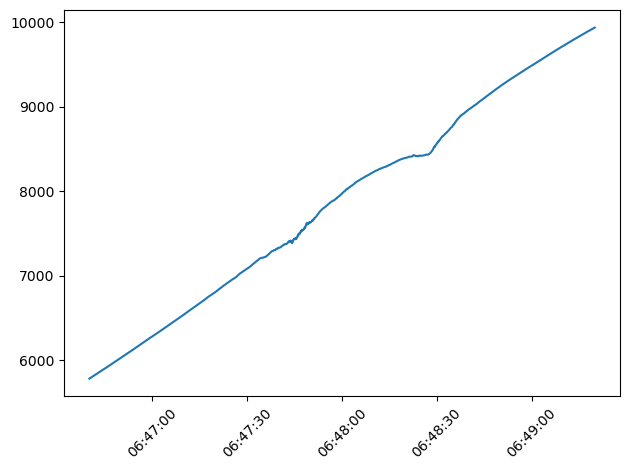

In [6]:
plt.plot(timestamps_b, bn)  # todo:: add latitude and so on information to the plot on x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

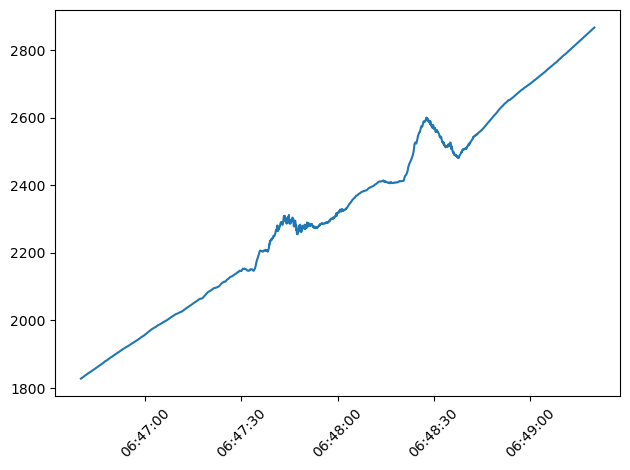

In [7]:
plt.plot(timestamps_b, be)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

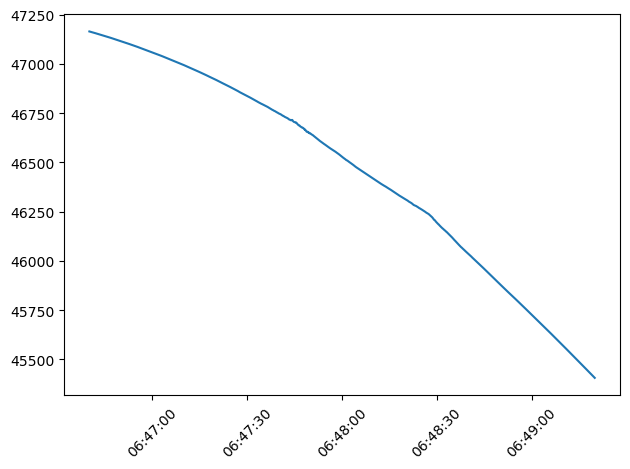

In [8]:
plt.plot(timestamps_b, bc)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# electric field in NEC coordinate system

## electric field in satellite-track coordinate system

In [9]:
Ehx = df_e['Ehx'].values
Ehy = df_e['Ehy'].values

## coordinate transformation from satellite-track coordinate system to NEC coordinate system

In [10]:
VsatN = df_e['VsatN'].values
VsatE = df_e['VsatE'].values
rotation_matrix_2d_nec2sc,rotation_matrix_2d_sc2nec = utils.get_rotation_matrices_nec2sc_sc2nec(VsatN,VsatE)

### preprocess before rotation

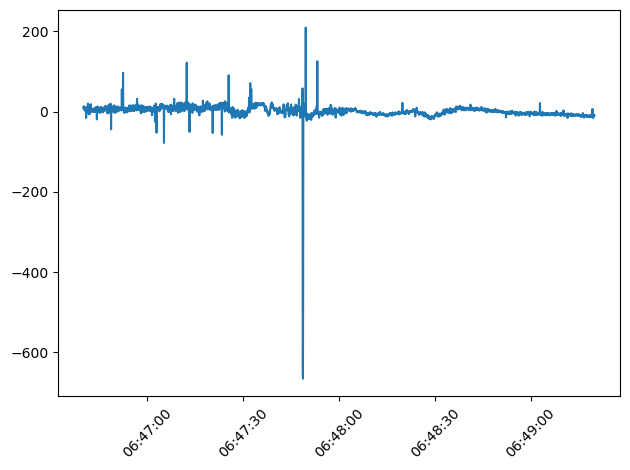

In [11]:
plt.plot(timestamps_e, Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [12]:
np.std(Ehx),np.mean(Ehx),np.max(Ehx),np.min(Ehx)

(23.041916, 1.0366622, 209.64946, -665.1797)

In [13]:
Ehx_set_outliers_nan = utils.set_outliers_nan_std(Ehx, print_=True)
Ehy_set_outliers_nan = utils.set_outliers_nan_std(Ehy, print_=True)

30
[ -43.9735     55.85131    96.95131    31.929352  -25.18946   -52.246895
  -77.74769    32.06451   122.04997    24.538439  -50.420204   27.311708
   25.95723   -52.979156  -57.540714   24.142708   25.899548   90.70911
   35.12801    71.15288    56.372738   31.657372   27.904247   58.08169
 -630.02313  -665.1797   -455.31207   209.64946   -22.509426  125.68604 ]
33
[  64.18146    69.17008    68.854675   67.748085   72.29167    63.576897
   71.010735   70.199295   79.56611    62.859295   72.29569    68.10827
   68.18476    65.32831    85.93454    71.88532    65.98927    62.882183
   71.72013    65.072205   68.92534    64.02373    63.6884     63.51877
   71.33222   -65.169945 1116.1362   1207.5975    117.2339     88.194145
   63.17441   -23.732807   -8.277935]


In [14]:
Ehx_set_outliers_nan_interpolated = utils.get_array_interpolated(timestamps_e, Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = utils.get_array_interpolated(timestamps_e, Ehy_set_outliers_nan)

### do rotation

In [15]:
Ehn,Ehe = utils.do_rotation(-Ehx_set_outliers_nan_interpolated, -Ehy_set_outliers_nan_interpolated, rotation_matrix_2d_sc2nec)
# note:: I add the negative sign to the x,y components of the electric field in the satellite-track coordinate system.

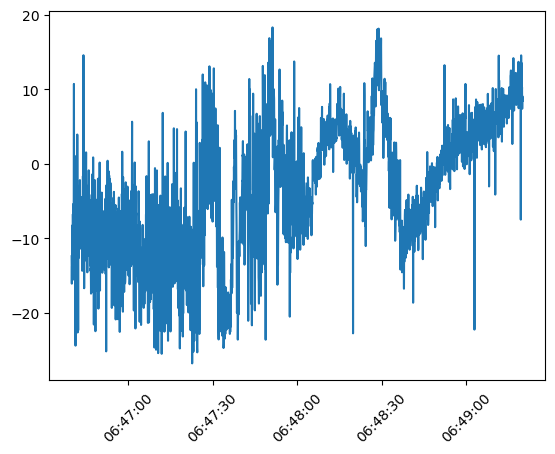

In [16]:
plt.plot(timestamps_e, Ehn)
plt.xticks(rotation=45)
plt.show()

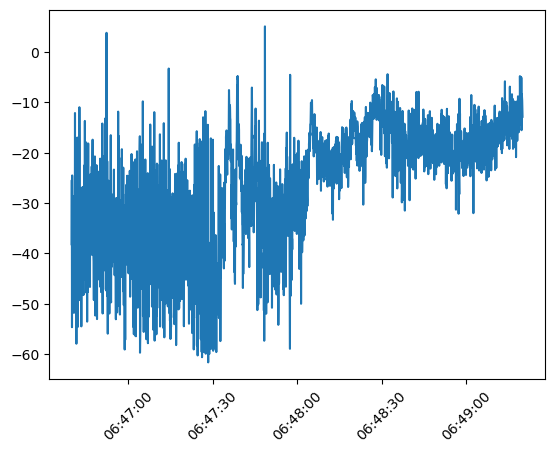

In [17]:
plt.plot(timestamps_e, Ehe)
plt.xticks(rotation=45)
plt.show()

# E north and B east

## original E and B

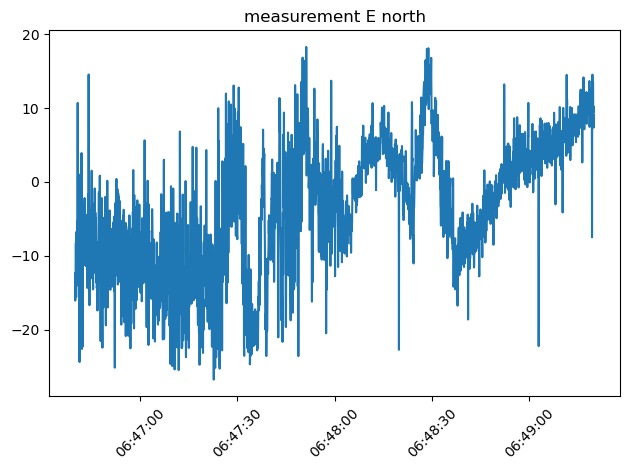

In [18]:
plt.plot(timestamps_e, Ehn)
plt.title("measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

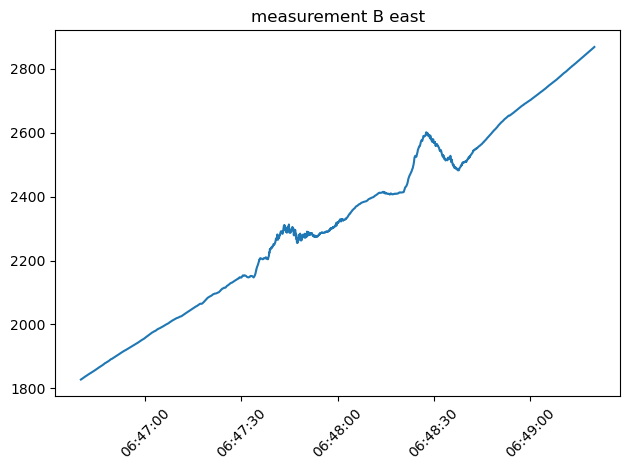

In [19]:
plt.plot(timestamps_b, be)
plt.title("measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## move average

In [20]:
mv_window_seconds = 20  # int
window_e = fs_e*mv_window_seconds
Ehn_mov_ave = utils.move_average(Ehn, window_e)

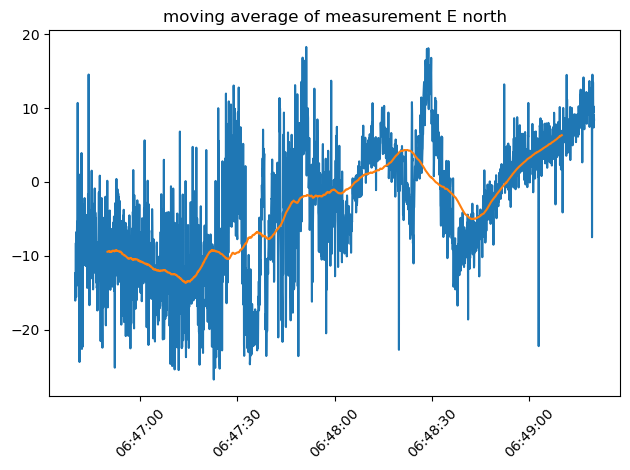

In [21]:
plt.plot(timestamps_e, Ehn)
plt.plot(timestamps_e, Ehn_mov_ave)
plt.title("moving average of measurement E north")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
window_b = fs_b*mv_window_seconds
be_mov_ave = utils.move_average(be, window_b)

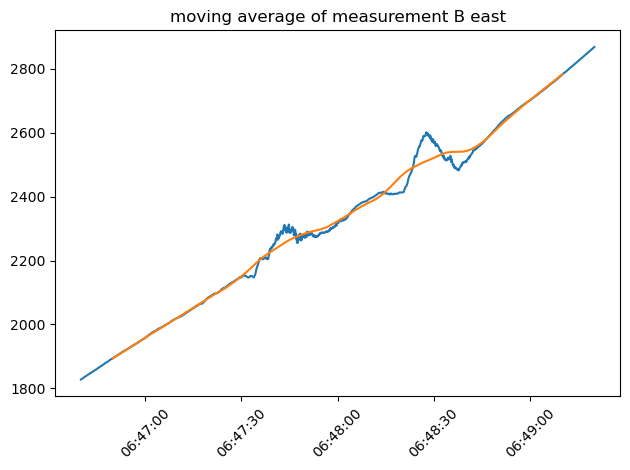

In [23]:
# plt.figure()
plt.plot(timestamps_b, be)
plt.plot(timestamps_b, be_mov_ave)
plt.title("moving average of measurement B east")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f'before and after moving average comparison')

## disturb field

delete the moving average of the field

In [24]:
Ehn_disturb = Ehn - Ehn_mov_ave
be_disturb = be - be_mov_ave

#### use analytical time to slice the disturb field

In [25]:
mask_e = np.where((timestamps_e >= utils.transform_time_string_to_datetime64ns(analytical_start_time)) & (timestamps_e <= utils.transform_time_string_to_datetime64ns(analytical_end_time)))  # mask for analytical time
mask_e

(array([ 320,  321,  322, ..., 2237, 2238, 2239], dtype=int64),)

In [26]:
analytical_timestamps_e = timestamps_e[mask_e]
analytical_Ehn_disturb = Ehn_disturb[mask_e]

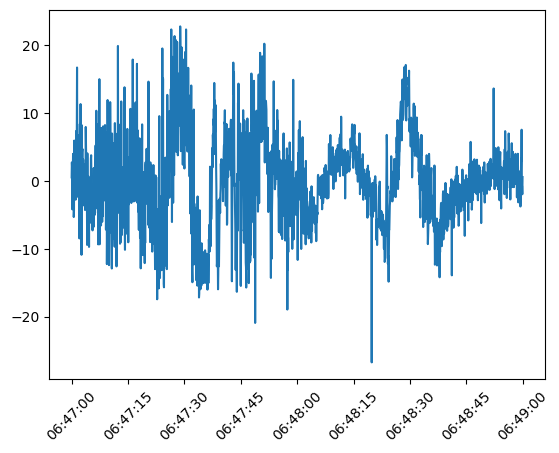

In [27]:
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb)
plt.xticks(rotation=45)
plt.show()

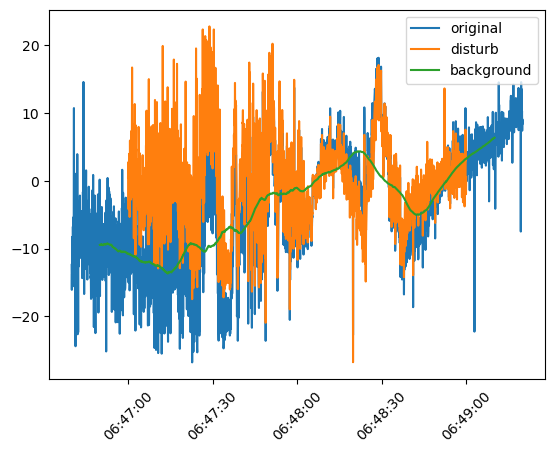

In [28]:
# original electric field and disturb electric field and background electric filed
plt.plot(timestamps_e,Ehn,label='original')
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb,label='disturb')
plt.plot(timestamps_e,Ehn_mov_ave,label='background')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [29]:
mask_b = np.where((timestamps_b >= utils.transform_time_string_to_datetime64ns(analytical_start_time)) & (timestamps_b <= utils.transform_time_string_to_datetime64ns(analytical_end_time)))  # mask for analytical time
mask_b

(array([1000, 1001, 1002, ..., 6997, 6998, 6999], dtype=int64),)

In [30]:
analytical_timestamps_b = timestamps_b[mask_b]
analytical_be_disturb = be_disturb[mask_b]

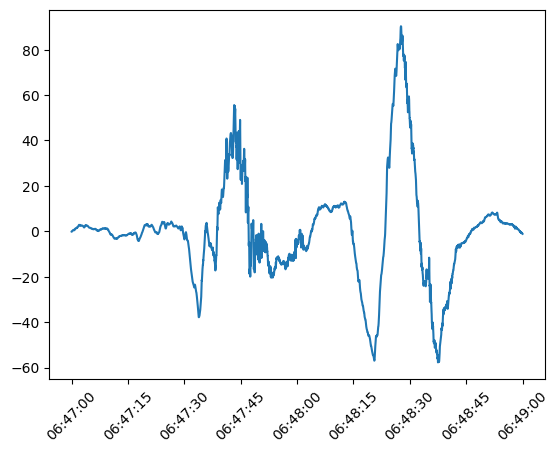

In [31]:
plt.plot(analytical_timestamps_b,analytical_be_disturb)
plt.xticks(rotation=45)
plt.show()

## filter

In [32]:
# IIR filter
lowcut=0.2
highcut=4
order=5
# get filter data
analytical_Ehn_disturb_filtered = utils.get_butter_filter(analytical_Ehn_disturb,fs_e,lowcut,highcut,order)
analytical_be_disturb_filtered = utils.get_butter_filter(analytical_be_disturb,fs_b,lowcut,highcut,order)

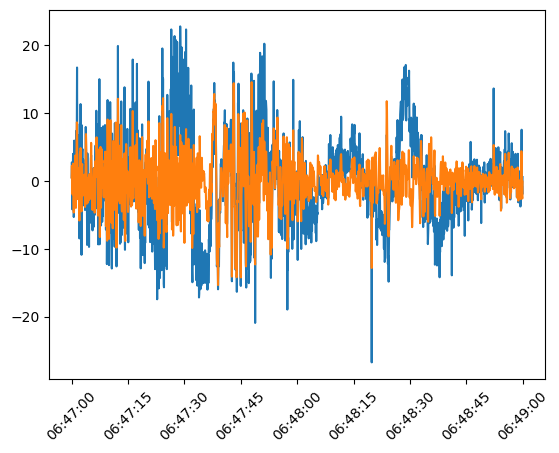

In [33]:
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb)
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb_filtered)
plt.xticks(rotation=45)
plt.show()

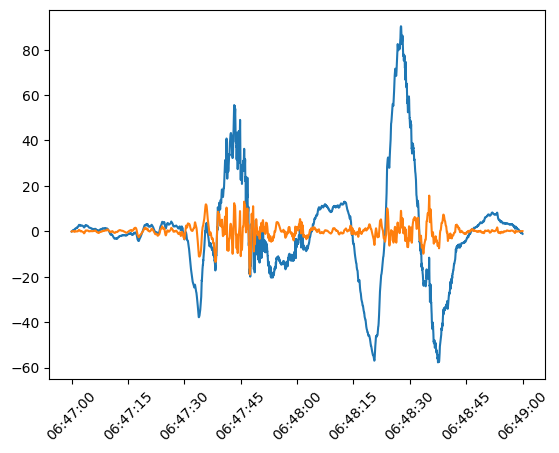

In [34]:
plt.plot(analytical_timestamps_b,analytical_be_disturb)
plt.plot(analytical_timestamps_b,analytical_be_disturb_filtered)
plt.xticks(rotation=45)
plt.show()

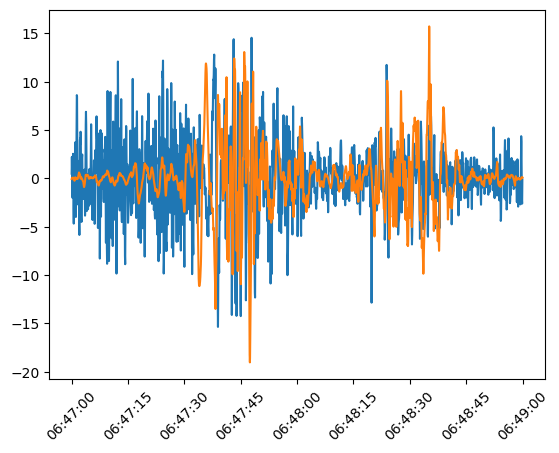

In [35]:
plt.plot(analytical_timestamps_e,analytical_Ehn_disturb_filtered)
plt.plot(analytical_timestamps_b,analytical_be_disturb_filtered)
plt.xticks(rotation=45)
plt.show()

## STFT

short-time Fourier transform

In [36]:
from scipy.signal import stft

# stft (spectral) basic parameters
window='hann'
stft_window_seconds=4  # second
nperseg_e = int(stft_window_seconds * fs_e)  # 每个窗的采样点数
noverlap_e = nperseg_e // 2  # 50%重叠
nperseg_b = int(stft_window_seconds * fs_b)
noverlap_b = nperseg_b // 2

# get stft
f_e, t_e, Zxx_e = stft(analytical_Ehn_disturb, fs_e, window=window, nperseg=nperseg_e, noverlap=noverlap_e,scaling='psd')
f_b, t_b, Zxx_b = stft(analytical_be_disturb, fs_b, window=window, nperseg=nperseg_b, noverlap=noverlap_b,scaling='psd')

In [37]:
t_e_dt64 = analytical_timestamps_e[0] + [np.timedelta64(int(_),'s') for _ in t_e]
t_b_dt64 = analytical_timestamps_b[0] + [np.timedelta64(int(_),'s') for _ in t_b]

### module

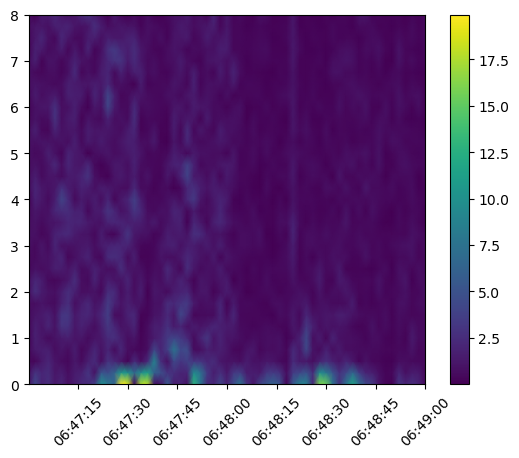

In [38]:
plt.pcolormesh(t_e_dt64, f_e, np.abs(Zxx_e), shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

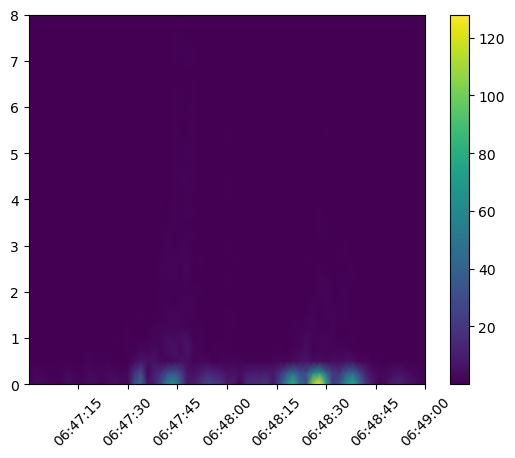

In [39]:
plt.pcolormesh(t_b_dt64, f_b, np.abs(Zxx_b), shading='gouraud')
plt.ylim([0,8])
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

### cross spectral

In [40]:
mask_f_b = np.where(f_b <= 8.0)
mask_f_b

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
       dtype=int64),)

In [41]:
f_b_mask = f_b[mask_f_b]
f_b_mask,f_e

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]))

In [42]:
Zxx_b_mask = Zxx_b[mask_f_b]
Zxx_b_mask.shape

(33, 61)

In [43]:
# confirm
np.all(t_e==t_b),np.all(t_e_dt64==t_b_dt64),np.all(f_e==f_b_mask),Zxx_b_mask.shape==Zxx_e.shape
# note:: because the fs between b and e is different, so the start time of b and e is fine different

(True, False, True, True)

In [44]:
cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b_mask)

#### module

In [45]:
cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
np.min(cross_e_b_spectral_density_module),np.max(cross_e_b_spectral_density_module),np.percentile(cross_e_b_spectral_density_module,95)

(3.4459414148942276e-05, 2056.7596666950794, 9.607242127605579)

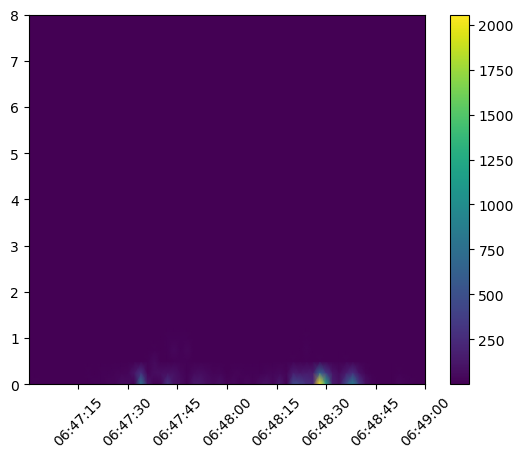

In [46]:
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

##### process the outliers

In [47]:
threshold = np.percentile(cross_e_b_spectral_density_module,95)  # note:: use 95% percentile not the maximum value
# set_value = np.min(cross_e_b_spectral_density_module)
# set_value = np.max(cross_e_b_spectral_density_module)
set_value = threshold
# note:: 设置为threshold更合理，同时这样设置后面的相位差绘制也更合理。可以设置为最小值或0来对比设置为threshold

modified_cross_e_b_spectral_density_module = utils.threshold_and_set(cross_e_b_spectral_density_module.copy(), threshold, set_value) # Use .copy() to avoid in-place modification

In [48]:
np.min(modified_cross_e_b_spectral_density_module),np.max(modified_cross_e_b_spectral_density_module)

(3.4459414148942276e-05, 9.607242127605579)

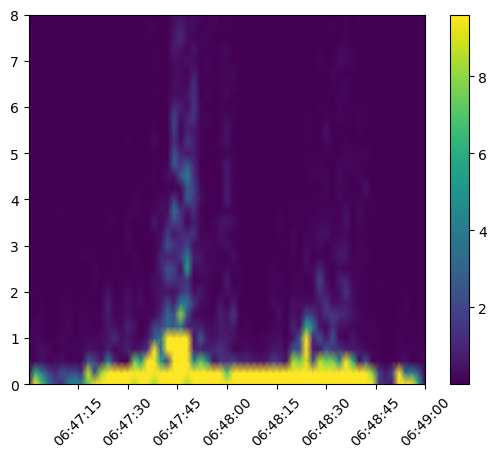

In [49]:
plt.pcolormesh(t_e_dt64, f_e, modified_cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

##### normalized

In [50]:
normalized_modified_cross_e_b_spectral_density_module = utils.normalize_to_01(modified_cross_e_b_spectral_density_module)
np.min(normalized_modified_cross_e_b_spectral_density_module),np.max(normalized_modified_cross_e_b_spectral_density_module),np.percentile(normalized_modified_cross_e_b_spectral_density_module,50)

(0.0, 1.0, 0.0045535813954491414)

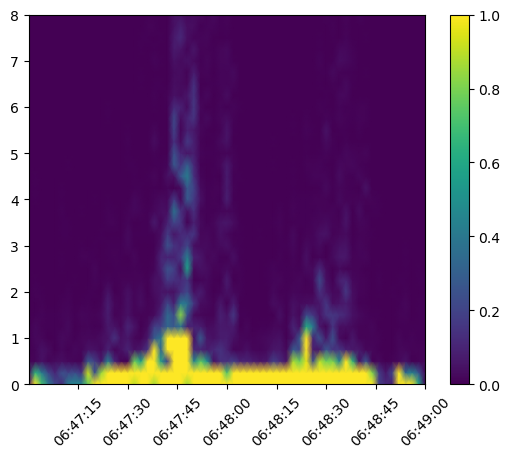

In [51]:
plt.pcolormesh(t_e_dt64, f_e, normalized_modified_cross_e_b_spectral_density_module, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

#### phase

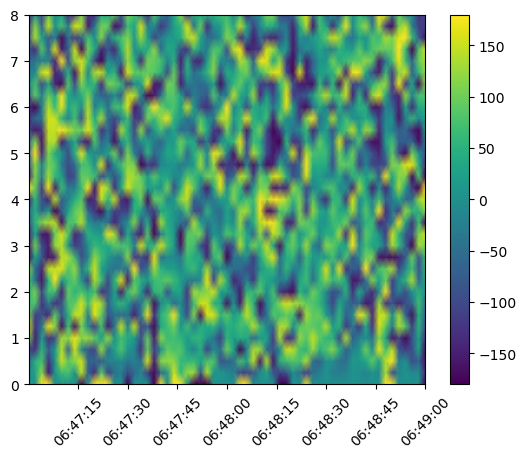

In [52]:
cross_e_b_spectral_density_phase = np.degrees(np.angle(cross_e_b_spectral_density))
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_phase, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()  # 交叉谱中很多由于数据本身的噪声的影响，导致相位图像没有规律

##### phase with threshold

In [53]:
cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase.copy()
cross_e_b_spectral_density_phase_mask[normalized_modified_cross_e_b_spectral_density_module<0.003] = np.nan
# note:: the threshold is set to 0.003 according to the 50 percentile of the normalized cross spectral density module
# note:: 也许不用

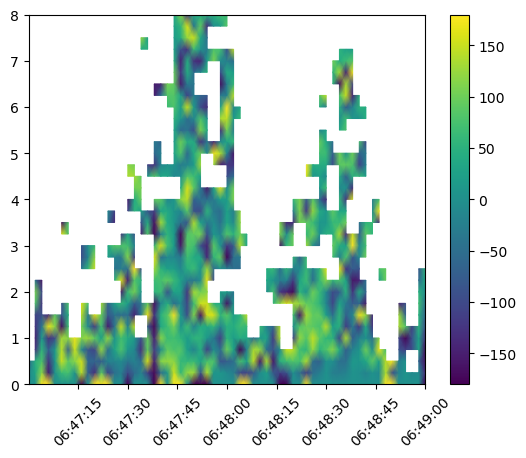

In [54]:
plt.pcolormesh(t_e_dt64, f_e, cross_e_b_spectral_density_phase_mask, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

# regions

## auroral region

### disturd: e vs b; disturb_filterd: e vs b

In [55]:
auroral_region_start_time = np.datetime64('2016-03-11T06:47:35','ns')
auroral_region_end_time = np.datetime64('2016-03-11T06:47:55','ns')  # note:: the time of auroral region is 20 seconds, that is the same as the moving average window time

In [56]:
auroral_e_mask = (analytical_timestamps_e >= auroral_region_start_time) & (analytical_timestamps_e <= auroral_region_end_time)
auroral_e_mask

array([False, False, False, ..., False, False, False])

In [57]:
auroral_timestamps_e = analytical_timestamps_e[auroral_e_mask]
auroral_Ehn_disturb = analytical_Ehn_disturb[auroral_e_mask]
auroral_Ehn_disturb_filterd = analytical_Ehn_disturb_filtered[auroral_e_mask]

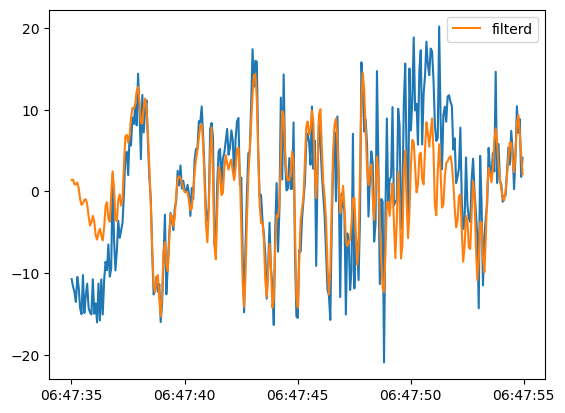

In [58]:
plt.plot(auroral_timestamps_e,auroral_Ehn_disturb)
plt.plot(auroral_timestamps_e,auroral_Ehn_disturb_filterd,label='filterd')
plt.legend()
plt.show()

In [59]:
auroral_b_mask = (analytical_timestamps_b >= auroral_region_start_time) & (analytical_timestamps_b <= auroral_region_end_time)
auroral_b_mask

array([False, False, False, ..., False, False, False])

In [60]:
auroral_timestamps_b = analytical_timestamps_b[auroral_b_mask]
auroral_be_disturb = analytical_be_disturb[auroral_b_mask]
auroral_be_disturb_filterd = analytical_be_disturb_filtered[auroral_b_mask]

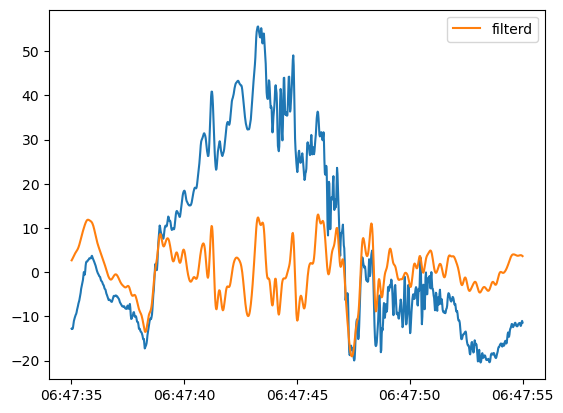

In [61]:
plt.plot(auroral_timestamps_b,auroral_be_disturb)
plt.plot(auroral_timestamps_b,auroral_be_disturb_filterd,label='filterd')
plt.legend()
plt.show()

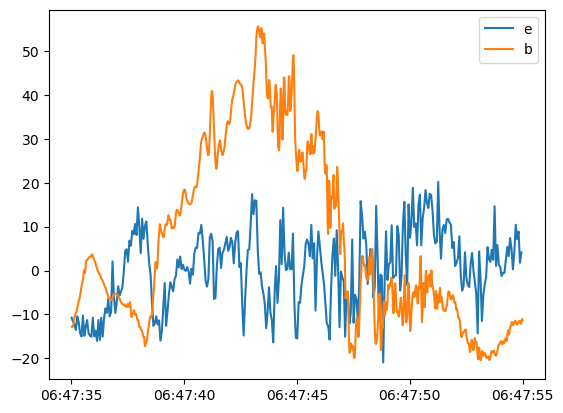

In [62]:
plt.plot(auroral_timestamps_e,auroral_Ehn_disturb,label='e')
plt.plot(auroral_timestamps_b,auroral_be_disturb,label='b')
plt.legend()
plt.show()

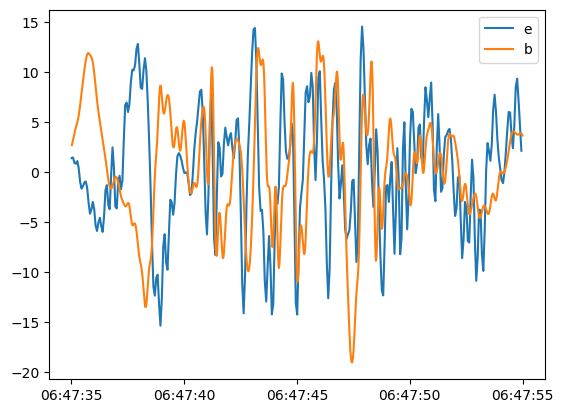

In [63]:
plt.plot(auroral_timestamps_e,auroral_Ehn_disturb_filterd,label='e')
plt.plot(auroral_timestamps_b,auroral_be_disturb_filterd,label='b')
plt.legend()
plt.show()

# fft

In [64]:
auroral_Ehn_disturb_fft = utils.FFT(auroral_Ehn_disturb,fs_e)

In [65]:
auroral_Ehn_disturb_fft.get_fft()

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
        3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
        3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
        4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
        4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45,
        5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  ,
        6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55,
        6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 ,
        7.15, 7.2 , 7.25, 7.3 , 7.35, 

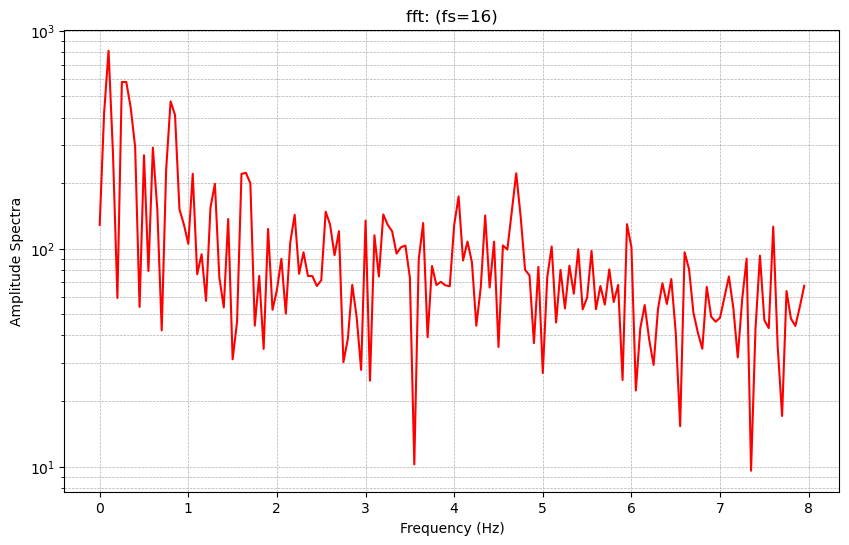

In [66]:
auroral_Ehn_disturb_fft.plot_fft()
plt.show()

In [67]:
auroral_be_disturb_fft = utils.FFT(auroral_be_disturb,fs_b)

In [68]:
auroral_be_disturb_fft.get_fft()

(array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
         1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
         2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
         2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
         3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
         3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
         4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
         4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
         4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
         5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
         5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
      

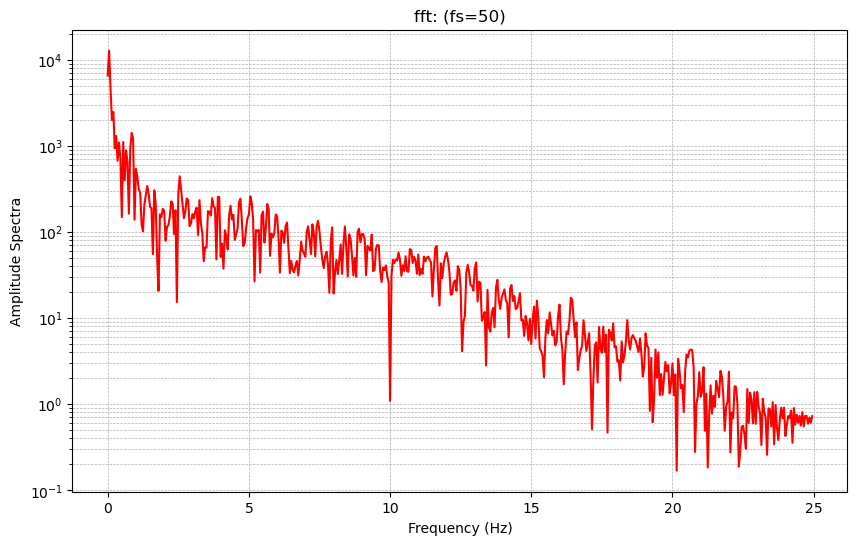

In [69]:
auroral_be_disturb_fft.plot_fft()
plt.show()

In [70]:
# one figure
freqs_e, amps_e, _ = auroral_Ehn_disturb_fft.get_fft()
freqs_b, amps_b, _ = auroral_be_disturb_fft.get_fft()
mask_b_fft = freqs_b < 8
freqs_b_mask = freqs_b[mask_b_fft]
amps_b_mask = amps_b[mask_b_fft]
np.all(freqs_e==freqs_b_mask)  # todo:: 相等意味着后续可以直接求比值。频率数组的取值间隔=$fs_e / len(e)$。此处可能有待优化。

True

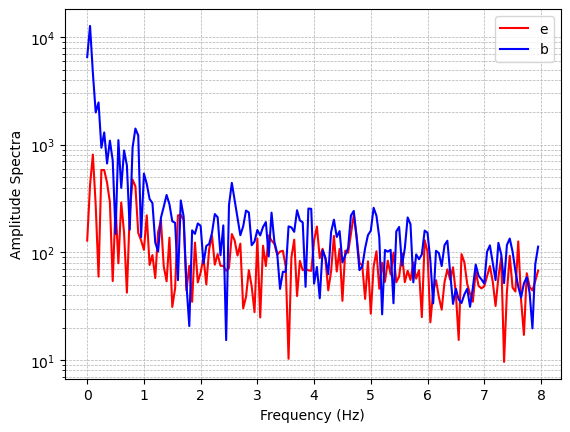

In [71]:
plt.plot(freqs_e, amps_e, color='red',label='e')
plt.plot(freqs_b_mask, amps_b_mask, color='blue',label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [72]:
eb_ratio_fft = amps_e/amps_b_mask
eb_ratio_fft_SI = eb_ratio_fft * 1e-3 * 1e9

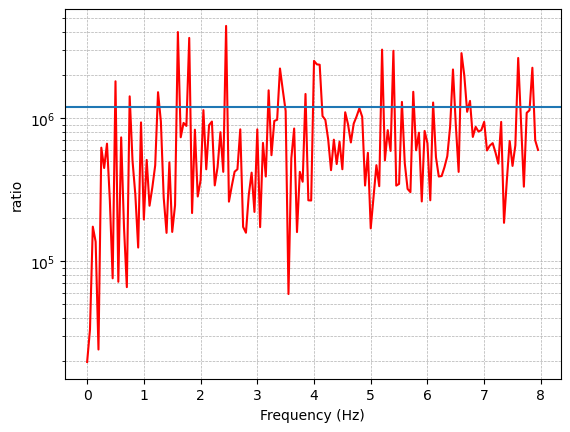

In [73]:
plt.plot(freqs_e, eb_ratio_fft_SI, color='red',label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [76]:
from scipy.signal import welch

# psd
freqs_e_psd_density, auroral_Ehn_disturb_psd_density = welch(auroral_Ehn_disturb, fs_e, scaling='density')

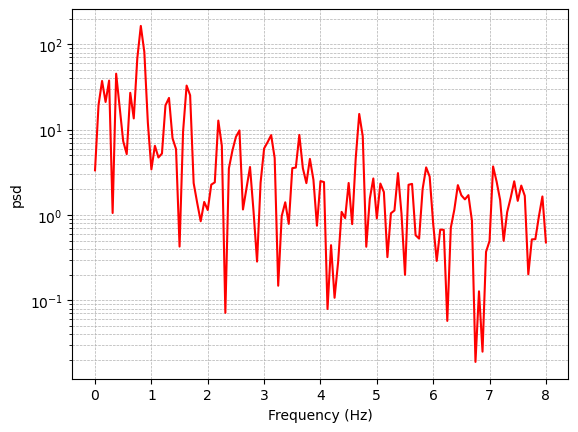

In [77]:
plt.plot(freqs_e_psd_density, auroral_Ehn_disturb_psd_density, color='red')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

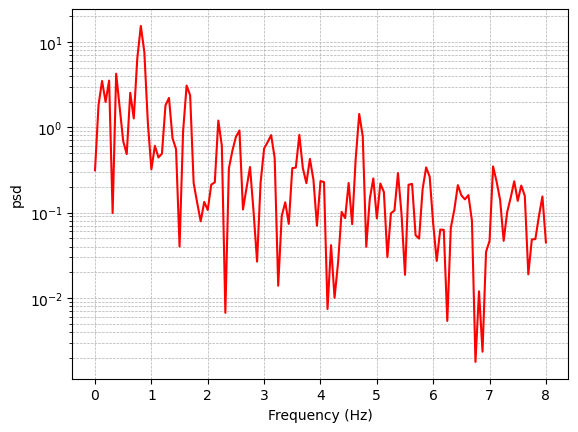

In [78]:
freqs_e_psd_spectrum, auroral_Ehn_disturb_psd_spectrum = welch(auroral_Ehn_disturb, fs_e, scaling='spectrum')

plt.plot(freqs_e_psd_spectrum, auroral_Ehn_disturb_psd_spectrum, color='red')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

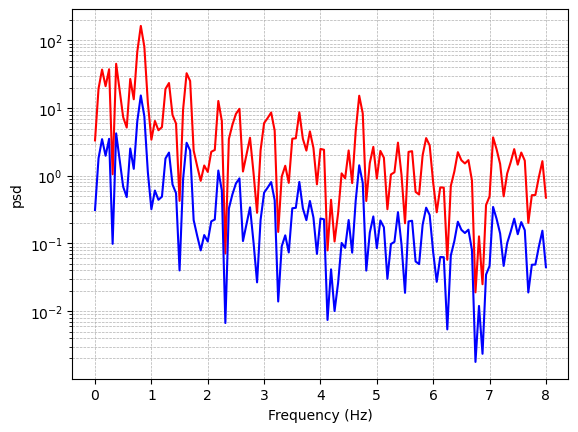

In [79]:
plt.plot(freqs_e_psd_density, auroral_Ehn_disturb_psd_density, color='red')
plt.plot(freqs_e_psd_spectrum, auroral_Ehn_disturb_psd_spectrum, color='blue')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # note:: 基本上是平移

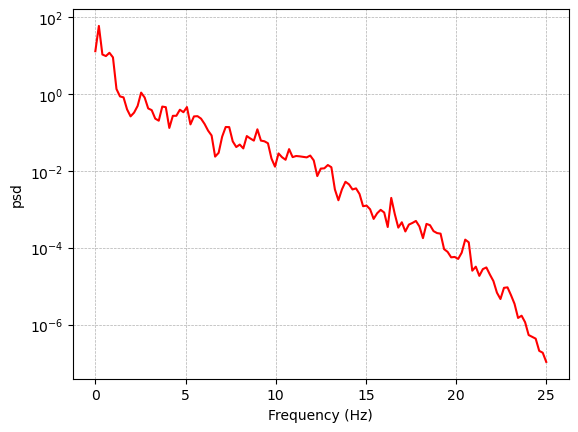

In [80]:
freqs_b_psd_spectrum, auroral_be_disturb_psd_spectrum = welch(auroral_be_disturb, fs_b, scaling='spectrum')

plt.plot(freqs_b_psd_spectrum, auroral_be_disturb_psd_spectrum, color='red')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('psd')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# ratio
# todo:: freqs不相同，需要调整welch参数使其相同
mask_b_psd = freqs_b_psd_spectrum<8
np.all(freqs_e_psd_spectrum)

### stft -> ratio

In [59]:
auroral_stft_mask = (t_b_dt64 >= auroral_region_start_time) & (t_b_dt64 <= auroral_region_end_time)
auroral_stft_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [60]:
auroral_t_b_dt64 = t_b_dt64[auroral_stft_mask]
auroral_Zxx_b = Zxx_b_mask[:, auroral_stft_mask]

auroral_t_e_dt64 = t_e_dt64[auroral_stft_mask]
auroral_Zxx_e = Zxx_e[:, auroral_stft_mask]

In [61]:
auroral_e_b_ratio = np.abs(auroral_Zxx_e) / np.abs(auroral_Zxx_b)
np.max(auroral_e_b_ratio),np.min(auroral_e_b_ratio),np.percentile(auroral_e_b_ratio,95)  # QA:: 一个异常值（最大值）

(2826.2025486242374, 0.025330805068584827, 16.268193122220392)

In [62]:
threshold = np.percentile(auroral_e_b_ratio,95)
set_value = threshold
modified_auroral_e_b_ratio = utils.threshold_and_set(auroral_e_b_ratio.copy(), threshold, set_value)

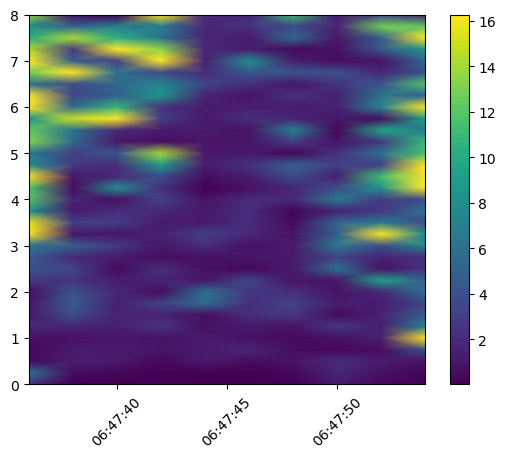

In [63]:
plt.pcolormesh(auroral_t_e_dt64, f_e, modified_auroral_e_b_ratio, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### counts

In [64]:
np.min(modified_auroral_e_b_ratio),np.max(modified_auroral_e_b_ratio),np.percentile(modified_auroral_e_b_ratio,50),np.percentile(modified_auroral_e_b_ratio,95)

(0.025330805068584827,
 16.268193122220392,
 2.1225605344966265,
 16.10635589265272)

In [65]:
# ratio_bins = np.linspace(0,np.max(modified_auroral_e_b_ratio),num)
# note:: not use above code to generate the bins, because don't know how to set a reasonable 'num'. 如果num设置小了，对于quiet的ratio来说，可能由于部分的大值导致bins的宽度过大，从而导致计数不合理

In [66]:
auroral_ratio_bins = np.arange(0,np.max(modified_auroral_e_b_ratio)+2,2)
auroral_ratio_bins

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

In [67]:
auroral_ratio_hist_counts = utils.get_ratio_hist_counts(f_e,modified_auroral_e_b_ratio,auroral_ratio_bins)

# hist_counts = np.zeros((len(f_e),len(auroral_ratio_bins)-1))
# for i,_ in enumerate(f_e):
#     hist_counts[i],_ = np.histogram(modified_auroral_e_b_ratio[i],bins=auroral_ratio_bins)

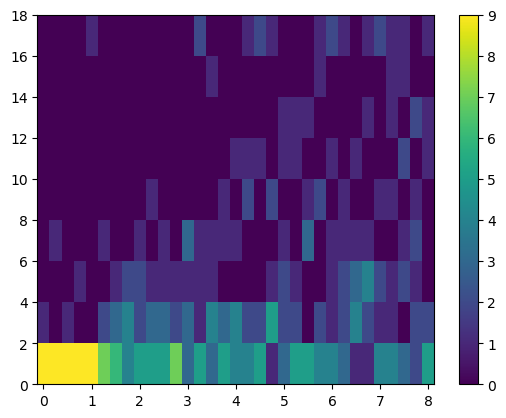

In [68]:
plt.pcolormesh(f_e,(auroral_ratio_bins[:-1]+auroral_ratio_bins[1:])/2,auroral_ratio_hist_counts.T)
plt.colorbar()
plt.show()  # todo:: 一个频率带内的比值的均值

### phase difference

with threshold

In [69]:
auroral_cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase_mask[:, auroral_stft_mask]

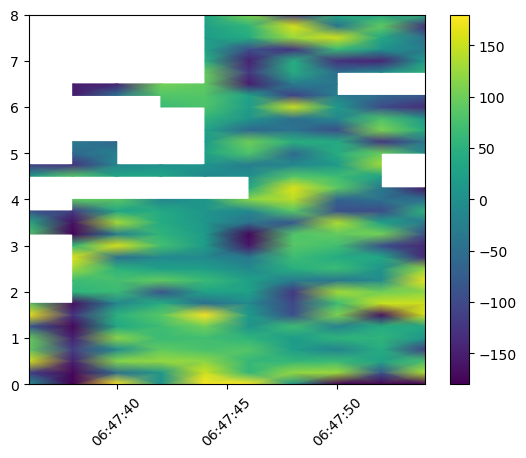

In [70]:
plt.pcolormesh(auroral_t_e_dt64,f_e,auroral_cross_e_b_spectral_density_phase_mask,shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### phase counts

In [71]:
num_bins = 50
phase_diff_bins,auroral_phase_diff_hist_counts = utils.get_phase_diff_hist_counts(f_e,auroral_cross_e_b_spectral_density_phase_mask,num_bins=num_bins)

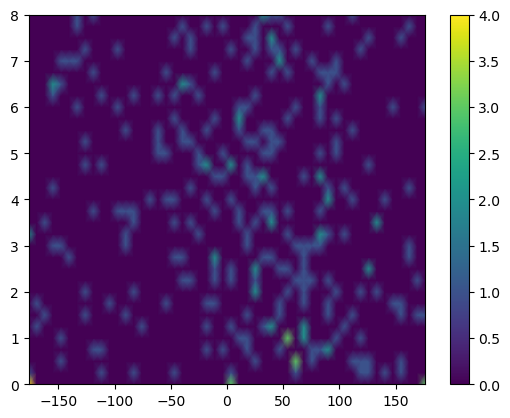

In [72]:
plt.pcolormesh((phase_diff_bins[:-1]+phase_diff_bins[1:])/2,f_e,auroral_phase_diff_hist_counts,shading='gouraud')
plt.colorbar()
plt.show()  # 看不出明显的规律。同quiet区域对比而言有一点区别，但也看不出。
# todo:: 使用 CWT 试试

## quiet

In [73]:
quiet_region_start_time = np.datetime64('2016-03-11T06:47:05','ns')
quiet_region_end_time = np.datetime64('2016-03-11T06:47:25','ns')

In [74]:
quiet_mask = (t_b_dt64 >= quiet_region_start_time) & (t_b_dt64 <= quiet_region_end_time)
quiet_mask

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [75]:
quiet_t_b_dt64 = t_b_dt64[quiet_mask]
quiet_Zxx_b = Zxx_b_mask[:,quiet_mask]
quiet_t_e_dt64 = t_e_dt64[quiet_mask]
quiet_Zxx_e = Zxx_e[:,quiet_mask]

### ratio

In [76]:
quiet_e_b_ratio = np.abs(quiet_Zxx_e) / np.abs(quiet_Zxx_b)
np.max(quiet_e_b_ratio),np.min(quiet_e_b_ratio),np.percentile(quiet_e_b_ratio,95)

(2212.3737587550695, 0.20998303735288681, 502.51564127120804)

In [77]:
threshold = np.percentile(quiet_e_b_ratio,95)
set_value = threshold
modified_quiet_e_b_ratio = utils.threshold_and_set(quiet_e_b_ratio.copy(), threshold, set_value)

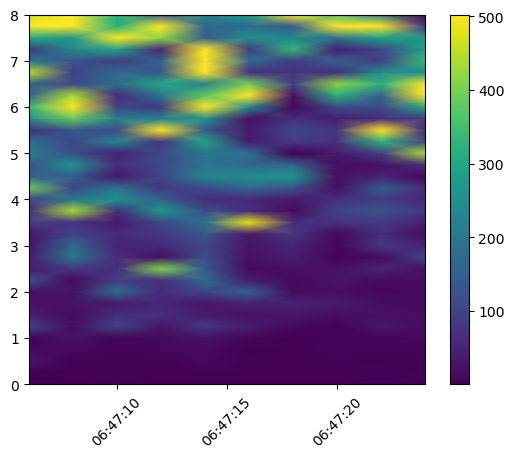

In [78]:
plt.pcolormesh(quiet_t_e_dt64, f_e, modified_quiet_e_b_ratio, shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### counts

In [79]:
np.min(modified_quiet_e_b_ratio),np.max(modified_quiet_e_b_ratio),np.percentile(modified_quiet_e_b_ratio,50),np.percentile(modified_quiet_e_b_ratio,95)

(0.20998303735288681, 502.51564127120804, 78.85964346218798, 502.5114304437966)

In [80]:
quiet_ratio_bins = np.arange(0,np.max(modified_quiet_e_b_ratio)+2,2)
quiet_ratio_bins

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

In [81]:
quiet_ratio_hist_counts = utils.get_ratio_hist_counts(f_e,modified_quiet_e_b_ratio,quiet_ratio_bins)

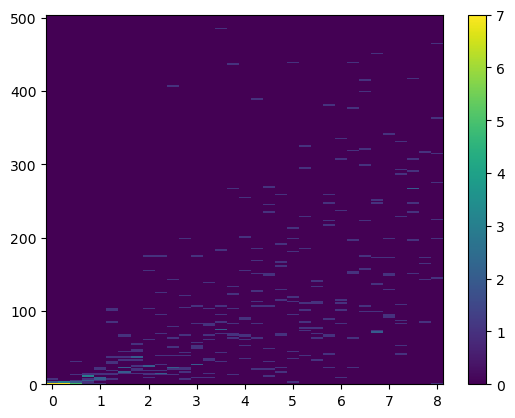

In [82]:
plt.pcolormesh(f_e,(quiet_ratio_bins[:-1]+quiet_ratio_bins[1:])/2,quiet_ratio_hist_counts.T)
plt.colorbar()
plt.show()  # todo:: 一个频率带内的比值的均值

### phase difference

In [83]:
quiet_cross_e_b_spectral_density_phase_mask = cross_e_b_spectral_density_phase_mask[:,quiet_mask]

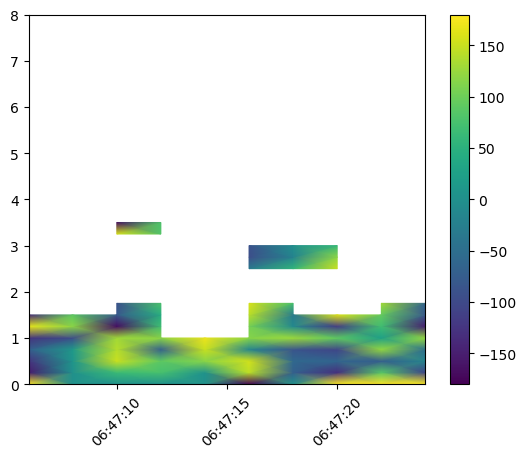

In [84]:
plt.pcolormesh(quiet_t_e_dt64,f_e,quiet_cross_e_b_spectral_density_phase_mask,shading='gouraud')
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

#### phase counts

In [85]:
num_bins = 50
phase_diff_bins,quiet_phase_diff_hist_counts = utils.get_phase_diff_hist_counts(f_e,quiet_cross_e_b_spectral_density_phase_mask,num_bins=num_bins)

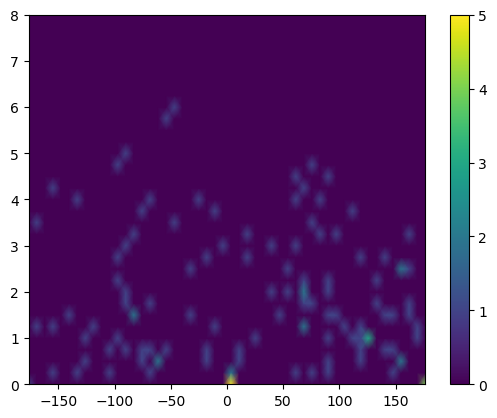

In [86]:
plt.pcolormesh((phase_diff_bins[:-1]+phase_diff_bins[1:])/2,f_e,quiet_phase_diff_hist_counts,shading='gouraud')
plt.colorbar()
plt.show()

# down-resample the MAGx_HR_1B data (50hz)

- 1b 算法文档中提到 vfm 有截止频率大约 9hz？(Swarm Level 1b Processor Algorithms. pdf, page20). so when down-resampling the MAGx_HR_1B magnetic field data to 16hz, don't firstly filter the data?